# Bank client outflow prediction.

The [database from Kaggle.com](https://www.kaggle.com/datasets/mathchi/churn-for-bank-customers) contains following features :
* RowNumber — row number
* CustomerId — customer identification number
* Surname — surename of a client
* CreditScore — credit score. (the higher the credit score the higher the frequency of getting a credit and returning  it)
* Geography — the origin country of a customer
* Gender — client's gender
* Age — client's age
* Tenure — how many years the client uses the banking service
* Balance — client's balance
* NumOfProducts — the number of services used by a client
* HasCrCard — whether the client has a credit card or not (1 — yes, 0 — no 
* IsActiveMember — if the client has an active member status (1 — yes, 0 — no)
* EstimatedSalary — estimated client's salary
* Exited — loyalty status, **the target value** (1 — exited client, 0 — loyal client)

In [1]:
# import main librariees
import pandas as pd
import numpy as np 
import os, sys

# Graphical libraries
import matplotlib.pyplot as plt 
import seaborn as sns 
import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline
plt.style.use('fast')

# ML libraries
from sklearn import linear_model, metrics, preprocessing, tree, ensemble
from sklearn.model_selection import train_test_split 

# set random seed
random_seed = 42

#set path
sys.path.insert(1, '../')

In [2]:
churn_data = pd.read_csv('../data/churn.zip', sep=',') 

# copy the bd to preserve the original dataset
churn_df = churn_data.copy()

# drop the useless feature RowNumber  
churn_df.drop(['RowNumber'], axis=1, inplace=True) 

# Create a new feature 'client status' to define the customers status explicitly
churn_df['client status'] = churn_df['Exited'].astype('category').cat.rename_categories({0:'Loyal', 1:'Exited'})

# drop non informative features
churn_df.drop(['CustomerId', 'Surname'], axis=1, inplace=True)

churn_df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,client status
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,Exited
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,Loyal
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,Exited
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0,Loyal
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,Loyal


## Ratio of exited clients to loyal clients

In [3]:
# data
df=churn_df['client status'].value_counts().sort_values(ascending=False)

fig = px.pie(
    data_frame = df,
    values = 'client status',
    names = df.index,
    width=500, height=400
)

fig.update_layout(
    title=dict(text="Fig.1 - Client distribution by status", x=0.5, y=0.1, xanchor='center'),
    legend_title_text='Status:'
)
#fig.update_traces(textposition='inside', textinfo='percent+label')
#fig.show();

fig.write_image('../figures/fig_1.png', engine="kaleido")

<center> <img src = "../figures/fig_1.png"></center>

The fig.1 represents the client distribution by status. There are some 10000 clients in the database. The majority 79.6% (7963 ppl) uses the banking service though some 20.4% (2037 ppl) decided to exit the bank.

## Customer balances distribution

Let us study customer balances exceeding randomly chosen value of 2500$ (clients who actually use their accounts). 

In [4]:
fig = px.box(
    data_frame = churn_df[churn_df['Balance'] > 2500],
    x = 'Balance',
    height=250, width=700, 
)

fig.update_layout(
    title=dict(text='Fig.2 - Customer balances distribution over $2500', x=.5, y=0.05, xanchor='center'),
    xaxis_title_text = 'balance, $', yaxis_title_text = 'clients'
)

#fig.show()
fig.write_image('../figures/fig_2.png', engine="kaleido")

# number of customers:
print(f"Number of customers which balance exceeds $2500: {churn_df[churn_df['Balance'] > 2500].shape[0]} people")

Number of customers which balance exceeds $2500: 6383 people


<center> <img src = "../figures/fig_2.png">

Fig.2 represents customers balances distribution exceeding $2500. Analyzing the figure one can admit:
* there are slightly less than 6400 clients which balance exceeds $2500. 
* half of them have an amount between $100 thousands and $140 thousands.

It shows that the majority of clients are relatively wealthy and they store some $ $120.000$ $\pm$ $ $30.000$ on their accounts.

# Balance distribution and client status

In [5]:
fig = px.box(
    data_frame = churn_df,
    x = 'Balance',
    y = 'client status',
    color = 'client status',
    height=300, width=800, 
)
fig.update_layout(
    title=dict(text='Fig.3 - Customer balances distribution by status', x=.5, y=0.05, xanchor='center'),
    xaxis_title_text = 'Balance, $', yaxis_title_text = 'Status', legend_title_text='Status', 
)

#fig.show()
fig.write_image('../figures/fig_3.png', engine="kaleido")

<center> <img src = "../figures/fig_3.png">

Analizing the fig.3, representing customers balances distribution by status, it can be admitted:
* most of the exited clients stored some sufficient amount of money on their accounts whereas loyal clients have varying balance.
* the mean balance of loyal clients of $92.000 is lower than that of exited - $109.000.

This points out that wealthy clients withdraw their money at once (without decreasing it steadily).

## Age to client status

In [6]:
fig = px.box(
    data_frame = churn_df,
    x = 'Age',
    y = 'client status',
    color = 'client status',
    width=800, height=300,
)
fig.update_layout(
    title=dict(text='Fig. 4 - age to status distribution', x=.5, y=0.05, xanchor='center'),
    xaxis_title_text = 'Age of client, years', yaxis_title_text = 'Status',  
    legend_title_text='Status:'
)
#fig.show()
fig.write_image('../figures/fig_4.png', engine="kaleido")

<center> <img src = "../figures/fig_4.png">

The age to client status distribution is shown on the fig.4. One can addmitt: 
* Median age of loyal clients is 36 years. The group contains many outliers, queing outside of the right boundary;
* Median age of the exited clients is 45 years. A half of them can be named as a 'risky age group' is within the range between 38 and 51 years. The bank managers should point attention to this age group.

## Credit rating vs estimated salary

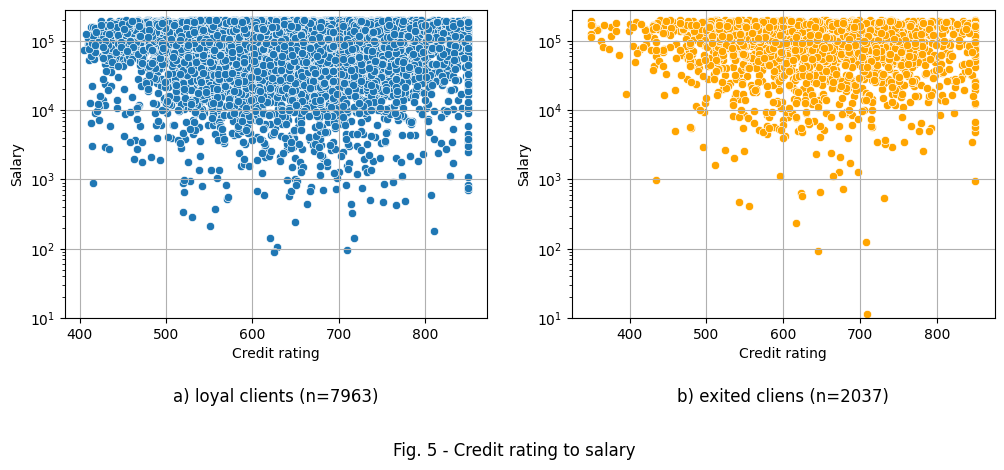

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# diagram1
sns.scatterplot(
    data=churn_df[churn_df['client status'] == 'Loyal'],
    x='CreditScore',
    y='EstimatedSalary', #marker="+",
    ax=ax[0]    
    ); 
# logarythmic scale
ax[0].set(yscale="log") #xscale="log"
ax[0].set_ylim(10, 2.8*10e4)
ax[0].set_xlabel('Credit rating')
ax[0].set_ylabel('Salary')
ax[0].grid();

# diagram2 
sns.scatterplot(
    data=churn_df[churn_df['client status'] == 'Exited'], #
    x='CreditScore',
    y='EstimatedSalary', 
    ax=ax[1],
    color='orange',
    ); 

# логарифмическая шкала по оси У
ax[1].set(yscale="log",) #xscale="log"
ax[1].set_ylim(10, 2.8*10e4)

ax[1].set_xlabel('Credit rating')
ax[1].set_ylabel('Salary')

ax[1].grid()

fig.suptitle('Fig. 5 - Credit rating to salary', fontsize=12, y=-0.20)
ax[0].set_title('a) loyal clients (n=7963)',y=-0.30,loc='center') #, , 
ax[1].set_title('b) exited cliens (n=2037)',y=-0.30,loc='center'); #, loc='center', y=-0.1

plt.savefig(f'../figures/fig_5.png')

Analyzing the credit rating to salary distribution on fig.5 it can be inferred:
* the rating does not correlate with salary in general. It implies that most of the client use the credit program.
* most of clients despite status are supposed to have salary between 100090 $\pm$ 57510 usd.

## Exited clients genders

In [8]:
df=churn_df[churn_df['client status'] == 'Exited']['Gender'].value_counts()

fig = px.pie(
    data_frame = df,
    values = 'Gender',
    names = df.index,
    width=400, height=300,
)

fig.update_layout(
    title=dict(text='Fig.6 - Genders of exited clients', x=.5, y=0.1, xanchor='center'),
    legend_title_text='Gender:'
)
#fig.show()
fig.write_image('../figures/fig_6.png', engine="kaleido");

# encoding
churn_df['Gender'] = churn_df['Gender'].apply(lambda x: 1 if x == 'Male' else '0')

<center> <img src = "../figures/fig_6.png">

Analyzing the fig.6 it can be addmitted, that women leave the bank more often than men.

## Number of services vs status

In [9]:
df = churn_df.groupby(['NumOfProducts', 'Exited'], as_index=False).count()

fig = px.bar(
    data_frame=df,
    x='NumOfProducts',
    y='client status',
    color='Exited',
    height=400,
    width=600,
    labels={'NumOfProducts':'Number of products',"client status":'Number of clients'},
    category_orders={'Exited': [1, 0]},
)

fig.update_layout(
    title=dict(text='Fig.7 - Services used by exit clients', x=.5, y=0.05, xanchor='center'),
    bargap=0.2
    #legend_title_text='Gender:'
)

#fig.show()
fig.write_image('../figures/fig_7.png', engine="kaleido")

<center> <img src = "../figures/fig_7.png"> </center>

The fig.7 represents the number of services used by clients in relation to their status. Analyzing the chart one can admit:
* loyal clients used bank services in average 3 times more actively than exited clients in general. 
* most of clients use up to 2 products. 
 
The figure indicates that exited clients were unsatisfied with the number of services or its quality.

## Active client status vs status

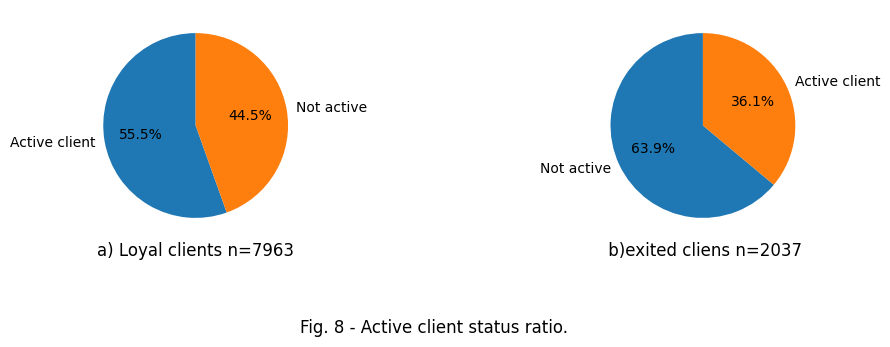

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3)) 
labels = 'Active client', 'Not active'
labels1 =  'Not active', 'Active client'

ax1.pie(
    churn_df[churn_df['client status'] == 'Loyal']['IsActiveMember'].value_counts().sort_values(ascending=False),
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
)


ax2.pie(
    churn_df[churn_df['client status'] == 'Exited']['IsActiveMember'].value_counts().sort_values(ascending=False),
    labels=labels1,
    autopct='%1.1f%%',
    startangle=90,
)

fig.suptitle('Fig. 8 - Active client status ratio.', fontsize=12, y=-0.15)
ax1.set_title('a) Loyal clients n=7963', loc='center', y=-0.1)
ax2.set_title(' b)exited cliens n=2037', loc='center', y=-0.1);

The fig.8 represent the active client status distribution by the bank usage status. As it can be seen from the charts loyal clients are more prone to have an 'active clients' unlike exited clients. It indicates that exited clients were more passive and most likely to use their accounts for savings.

# Exited clients distribution by country

In [11]:
#df = churn_data.groupby(['Geography'], as_index=False).mean(numeric_only=True)
df = churn_df[churn_df['Exited']==1].groupby(by='Geography', as_index=False).agg('count')
#Количество 
display(df[['Geography', 'Exited']])

# построим картограмму с помощью библиотеки Plotly
fig = px.choropleth(
    df,
    locations="Geography",
    locationmode = "country names",
    color='Exited', 
    width=600,
    height=400,
    color_continuous_scale="Peach", # Burg
    scope='europe',
)
fig.update_layout(title=dict(text='Fig. 9 - Exited clients distribution by country', x=.5, y=0.05, xanchor='center')
)
fig.update_geos(
    center=dict(lon=2, lat=50),
    lataxis_range=[-5,20], 
    lonaxis_range=[38, 51]
)

fig.show()
fig.write_image('../figures/fig_9.png', engine="kaleido")

,Geography,Exited
0,France,810
1,Germany,814
2,Spain,413


<center> <img src = "../figures/fig_9.png"> </center>

Fig 9 represent clients status distribution by countries. Analyzing the diagram one can conclude that exited clients live in following countries: Germany(40%) , France(40%), Spain(20%)

# Credit score vs tenure

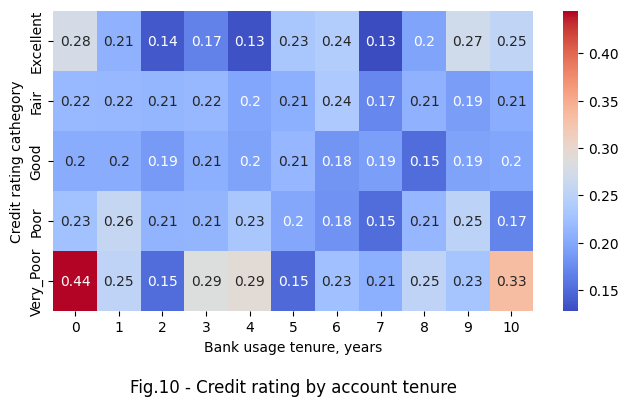

In [12]:
# rating split by 5 groups
def get_credit_score_cat(credit_score):
    if credit_score >= 300 and credit_score < 500:
        return "Very_Poor"
    elif credit_score >= 500 and credit_score < 601:
        return "Poor"
    elif credit_score >= 601 and credit_score < 661:
        return "Fair"
    elif credit_score >= 661 and credit_score < 781:
        return "Good"
    elif credit_score >= 781 and credit_score < 851:
        return "Excellent"
    elif credit_score >= 851:
        return "Top"
    elif credit_score < 300:
        return "Deep"
    
# Create a new feature 'CreditScoreCat'
churn_df['CreditScoreCat'] = churn_df['CreditScore'].apply(get_credit_score_cat) 

fig = plt.figure(figsize=(6, 3))
ax = fig.add_axes((0, 0, 1, 1))

df = churn_df.pivot_table(values='Exited', index='CreditScoreCat', columns='Tenure', aggfunc='mean')

sns.heatmap(df, annot=True, cmap= 'coolwarm'); #linewidths=.05

ax.set_title('Fig.10 - Credit rating by account tenure', fontsize=12, y=-0.3)
ax.set_xlabel('Bank usage tenure, years')
ax.set_ylabel('Credit rating cathegory');

plt.savefig(f'../figures/fig_10.png')

Fig.10 represents the credit rating distribution by account tenure in years. Analyzing the figure it can be noted:
* clients with a very poor credit rating are prone to leave the bank despite their account tenure. Maximum probability of exiting is noted within the years: 0, 3, 4 and 10.
* clients in other groups do not show significant tendency to exit

It can be recommended to point attention on that customer group.

## Correlation between features

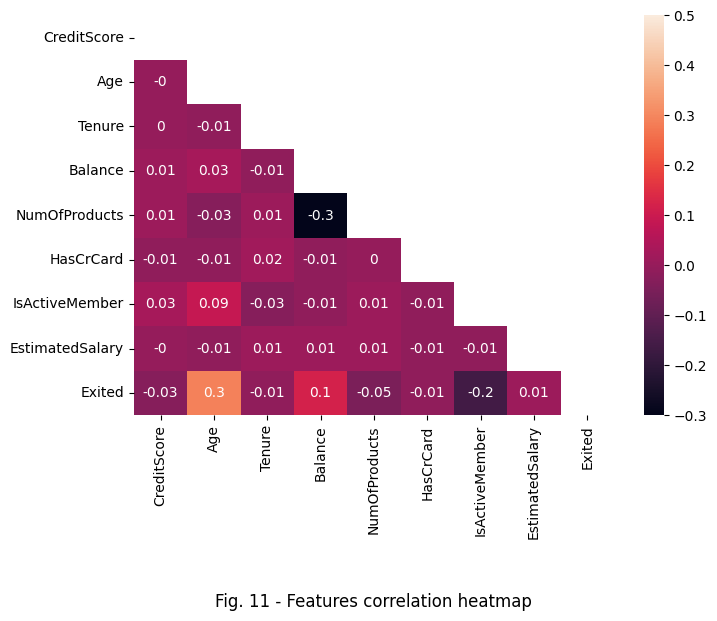

In [13]:
# let us delete repetitive features
churn_df.drop(['client status', 'CreditScoreCat'], axis=1, inplace=True)

fig = plt.figure(figsize=(6, 4))
ax = fig.add_axes((0, 0, 1, 1))
matrix = np.triu(churn_df.corr(numeric_only=True))

fig = sns.heatmap(churn_df.corr(numeric_only=True).round(2), annot=True, fmt='.1g', vmax=0.5, mask=matrix) #, vmax=0.3
ax.set_title('Fig. 11 - Features correlation heatmap', fontsize=12, y=-0.5);
plt.savefig('../figures/fig_11.png')

As it can be seen from the heatmap on the fig. 11 one can admit:
* the correlation values do not exceed some 0.3. Thus, there is no multicollinearity between features
* maximal positive correlation is observed between the client's age and his status (target value). One can say elder clients leave the bank;
* maximal negative correlation is observed between the client's balance  and the Number of products. The higher the balance the lower the number of services used by the client.


# Feature Engineering.

Let us create new features:
* BalanceSalaryRatio — balance to salary ratio;
* TenureByAge — tenure by age ratio;
* CreditScoreGivenAge — credit ration to age ratio.

In [14]:
churn_data['BalanceSalaryRatio'] = churn_data['Balance']/churn_data['EstimatedSalary']
churn_data['TenureByAge'] = churn_data['Tenure']/(churn_data['Age'])
churn_data['CreditScoreGivenAge'] = churn_data['CreditScore']/(churn_data['Age'])

churn_data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,0.000000,0.047619,14.738095
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,0.744677,0.024390,14.829268
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1.401375,0.190476,11.952381
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0.000000,0.025641,17.923077
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,1.587055,0.046512,19.767442


# Modelling: Germany

Suppose causes of the client outflow are varying by country. So let us create different models for each county. 

In [15]:
churn_data_cleaned = churn_df[churn_df['Geography'] == 'Germany']
print('Shape:', churn_data_cleaned.shape)
# (2509, 14)
churn_data_cleaned.head()

Shape: (2509, 11)


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
7,376,Germany,0,29,4,115046.74,4,1,0,119346.88,1
15,616,Germany,1,45,3,143129.41,2,0,1,64327.26,0
16,653,Germany,1,58,1,132602.88,1,1,0,5097.67,1
26,756,Germany,1,36,2,136815.64,1,1,1,170041.95,0
28,574,Germany,0,43,3,141349.43,1,1,1,100187.43,0


Let us delete non informative features.

In [16]:
churn_data_cleaned = churn_data_cleaned.drop(['Geography', 'Gender'], axis=1).rename(columns={'Пол':'Gender'}) #delete and rename features
print('Shape:', churn_data_cleaned.shape)
churn_data_cleaned.head()

Shape: (2509, 9)


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
7,376,29,4,115046.74,4,1,0,119346.88,1
15,616,45,3,143129.41,2,0,1,64327.26,0
16,653,58,1,132602.88,1,1,0,5097.67,1
26,756,36,2,136815.64,1,1,1,170041.95,0
28,574,43,3,141349.43,1,1,1,100187.43,0


### Check for missed data.

In [17]:
churn_data_cleaned.isnull().sum()

CreditScore        0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

Let us assign the target to a separate variable

In [18]:
X, y = churn_data_cleaned.drop("Exited", axis=1), churn_data_cleaned["Exited"]

Normalization

In [19]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

Let us study classes in target value.

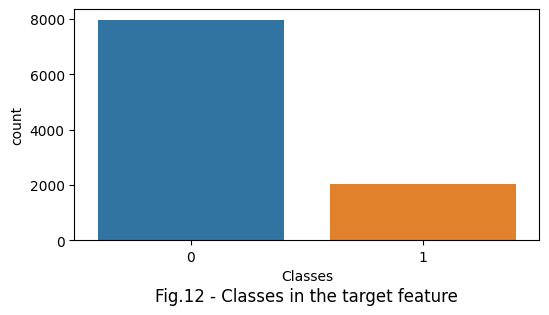

In [20]:
y.value_counts(normalize=True)

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
fig = sns.countplot(data = churn_data, x='Exited');
ax.set_title('Fig.12 - Classes in the target feature', y=-0.3)
ax.set_xlabel('Classes');
plt.savefig('../figures/fig_12.png')

As we can see from the histogram, data classes in the target value are unbalances. Therefore, we shall use straitfied 
split method.

## Model logistic regression
We will use $F1$-score to reach balance between $precision$ and $recall$ since we have unbalanced classes.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, random_state=0) #random_seed

print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1881, 8)
Test shape: (628, 8)


In [22]:
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1881, 8)
Test shape: (628, 8)


Проверим, что число лояльных и ушедших клиентов примерно одинаково в каждой из выборок:

In [23]:
print('Train :\n', y_train.value_counts(normalize=True).round(2))
print('Test :\n', y_test.value_counts(normalize=True).round(2))

Train :
 0    0.68
1    0.32
Name: Exited, dtype: float64
Test :
 0    0.68
1    0.32
Name: Exited, dtype: float64


### Model logistic regression

In [24]:
# Creation of an instance of the log model
log_reg = linear_model.LogisticRegression(
    solver='sag', #optimization algorythm
    class_weight='balanced', # balancing classes weights
    random_state=0, 
    max_iter=1000  
)
# Training the model
log_reg.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=0,
                   solver='sag')

In [25]:
# Prediction for trainand valid samples
y_train_pred = log_reg.predict(X_train)
y_test_pred = log_reg.predict(X_test)

# Metrix report
print(metrics.classification_report(y_test, y_test_pred))

#print('F1 score for train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('F1 score for test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

              precision    recall  f1-score   support

           0       0.81      0.67      0.73       424
           1       0.49      0.67      0.57       204

    accuracy                           0.67       628
   macro avg       0.65      0.67      0.65       628
weighted avg       0.71      0.67      0.68       628

F1 score for test: 0.57


### Polynomial regression of 3d power

In [26]:
# Creation of a generator of polynomial features
poly = preprocessing.PolynomialFeatures(degree=3, include_bias=False)
poly.fit(X_train)
# Features generation
X_train_poly = poly.transform(X_train)
X_test_poly = poly.transform(X_test)
# get results
print(X_train_poly.shape)
print(X_test_poly.shape)

print(f'Number of polynomial features:',X_train_poly.shape[1])

(1881, 164)
(628, 164)
Number of polynomial features: 164


In [27]:
# Creation an instance of the Logistics regression class
log_reg = linear_model.LogisticRegression(
    solver='sag', # optimization algorythm
    random_state=random_seed,
    max_iter=1000  
)
# Train the Model minimizing the logloss
log_reg.fit(X_train_poly, y_train)

# Prediction for train data and validation data
y_train_pred = log_reg.predict(X_train_poly)
y_test_pred = log_reg.predict(X_test_poly)

# Calculation of metrics
print(metrics.classification_report(y_test, y_test_pred))

# Creation of the metrics report
print('F1-score for validation sample: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

              precision    recall  f1-score   support

           0       0.80      0.91      0.85       424
           1       0.73      0.52      0.61       204

    accuracy                           0.78       628
   macro avg       0.76      0.71      0.73       628
weighted avg       0.78      0.78      0.77       628

F1-score for validation sample: 0.61


### Optimization of the probability threshold for log regression model

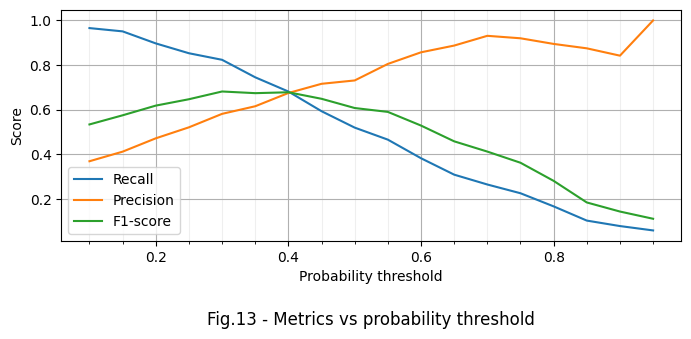

In [28]:
# Calculation of exiting probabilities for log regression
y_test_proba_pred = log_reg.predict_proba(X_test_poly)[:, 1]

# Empty lists to store results 
recall_scores, precision_scores, f1_scores = [], [], []

# Create 20 values of alpha between 0.1 and 1
thresholds = np.arange(0.1, 1, 0.05)

# calculation for each threshold
for threshold in thresholds:
    # clients with the probability > threshold assign to the class 1, else - to class 0
    y_test_pred = np.where(y_test_proba_pred>threshold,1,0)
    #y_test_proba_pred.apply(lambda x: 1 if x> else 0)
    
    # add calculated metrics to the list
    recall_scores.append(metrics.recall_score(y_test, y_test_pred))
    precision_scores.append(metrics.precision_score(y_test, y_test_pred))
    f1_scores.append(metrics.f1_score(y_test, y_test_pred))

# Visualization of the prediction errors
fig, ax = plt.subplots(figsize=(8, 3)) 
ax.plot(thresholds, recall_scores, label='Recall')
ax.plot(thresholds, precision_scores, label='Precision')

# Major ticks every 20, minor ticks every 5
#major_ticks = np.arange(0, 101, 20)
minor_ticks = np.arange(0, 1, 0.05)
ax.set_xticks(minor_ticks, minor=True)

ax.plot(thresholds, f1_scores, label='F1-score')
ax.set_title('Fig.13 - Metrics vs probability threshold', y=-0.4)
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
ax.legend()
ax.grid()
ax.grid(which='minor', alpha=0.2);

plt.savefig('../figures/fig_13.png')

The fig.13 displays metrics change by the probability threshold. Analyzing the graph it is possible to infer:
* model precision rises when the probability increases. The recall metrics, however, decreases stadily. It implies when we move the threshold value closer to 1 we classify cients as 'exited' only when we become more and more confident in it.
* the F1-score rises stadily until it reaches 0.68 (threshold=0.3) and then goes downward. 
* all 3 metrics have a common value 0.4.

In [29]:
f1_scores = np.array(f1_scores)

# index of the highest f1-score
best_f1_score = thresholds[np.argmax(f1_scores)].round(2)

print(f'Max f1-score: {np.max(f1_scores).round(3)} at the probability: {best_f1_score}')

Max f1-score: 0.682 at the probability: 0.3


In [30]:
# Set optimal threshold
threshold_opt = best_f1_score
# Set classes: 1 for clients whose probability of exit is above threshold, else class 0
#y_pred_opt = y_test_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
y_pred_opt = np.where(y_test_proba_pred>threshold_opt,1,0)

# calculation of metrics
print(metrics.classification_report(y_test, y_pred_opt))
print(f'F1 score for validation sample: {metrics.f1_score(y_test, y_pred_opt).round(3)}')

              precision    recall  f1-score   support

           0       0.89      0.71      0.79       424
           1       0.58      0.82      0.68       204

    accuracy                           0.75       628
   macro avg       0.74      0.77      0.74       628
weighted avg       0.79      0.75      0.76       628

F1 score for validation sample: 0.682


### Decison tree model

In [31]:
# Creation an instance of the Decision tree class
dt = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности 
    max_depth=8, #максимальная глубина
    min_samples_leaf = 10, # Минимальное число объектов в листе
    random_state=random_seed #генератор случайных чисел
)
# Train the Model
dt.fit(X_train, y_train)

# Prediction for train data
y_pred_train = dt.predict(X_train)

# Calculation of metrics
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_pred_train)))

# Prediction for validation data
y_pred_test = dt.predict(X_test)
# Calculation of metrics
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_pred_test)))

Train: 0.71
Test: 0.64


### Random forest model

In [32]:
# Creation an instance of the RandomForest class
rf = ensemble.RandomForestClassifier(
    n_estimators=500, 
    criterion='entropy', 
    max_depth=8, 
    min_samples_leaf = 10, 
    #max_features='sqrt', 
    random_state=random_seed 
)
# Train the model 
rf.fit(X_train, y_train)

# Predicting
y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)

# Metrics report
print('Train f1-score: {:.2f}'.format(metrics.f1_score(y_train, y_pred_train)))
print('Test  f1-score: {:.2f}'.format(metrics.f1_score(y_test, y_pred_test)))

Train f1-score: 0.72
Test  f1-score: 0.64


#### Model optimization

In [33]:
from sklearn.model_selection import RandomizedSearchCV

In [34]:
param_distributions = {
    'n_estimators': list(range(20, 200, 20)),
    'criterion': ["gini", "entropy", "log_loss"],
    'max_depth': list(np.linspace(5, 40, 5, dtype=int)),
    'min_samples_leaf': list(range(2, 10, 2))
}
            
random_search_forest = RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=random_seed), 
    param_distributions=param_distributions, 
    cv=5,
    n_iter = 10, 
    n_jobs = -1
)  
%time random_search_forest.fit(X_train, y_train) 
y_train_pred = random_search_forest.predict(X_train)
#print('f1_score for train_sa: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
#print("accuracy на тестовом наборе: {:.2f}".format(random_search_forest.score(X_test, y_test)))
y_test_pred = random_search_forest.predict(X_test)
print('f1_score for validation sample: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Best hyperparameters are: {}".format(random_search_forest.best_params_))

CPU times: total: 781 ms
Wall time: 9.35 s
f1_score for: 0.67
Наилучшие значения гиперпараметров: {'n_estimators': 160, 'min_samples_leaf': 2, 'max_depth': 13, 'criterion': 'gini'}


Try the best parameters

In [36]:
# Creation an instance of the RandomForest class
rf = ensemble.RandomForestClassifier(
    n_estimators=160, 
    criterion='gini', 
    max_depth=22, 
    min_samples_leaf = 2, 
    random_state=random_seed 
)
# Train the model 
rf.fit(X_train, y_train)

# Predicting
y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)

# Metrics report
print('Train f1-score: {:.2f}'.format(metrics.f1_score(y_train, y_pred_train)))
print('Test  f1-score: {:.2f}'.format(metrics.f1_score(y_test, y_pred_test)))

Train f1-score: 0.95
Test  f1-score: 0.66


In [37]:
# Calculation of exiting probabilities for the RandomForest
y_test_proba_pred = rf.predict_proba(X_test)[:, 1]

C:\Users\Lena\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



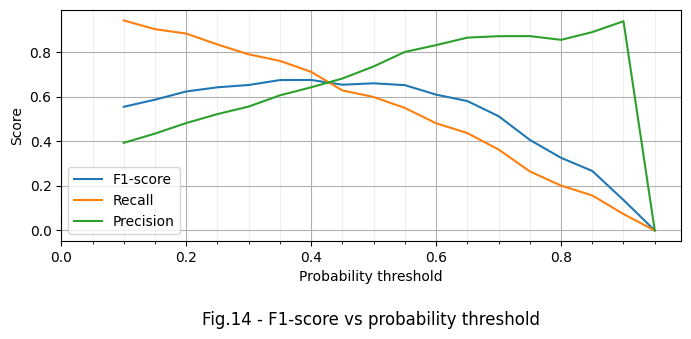

In [38]:
# Empty lists to store results 
recall_scores, precision_scores, f1_scores = [], [], []
# Create 20 values of alpha between 0.1 and 1
thresholds = np.arange(0.1, 1, 0.05)
# calculation for each threshold
for threshold in thresholds:
    # clients with the probability > threshold assign to the class 1, else - to class 0
    y_test_pred = np.where(y_test_proba_pred>threshold, 1, 0)
    
    # Calculation of metrics
    f1_scores.append(metrics.f1_score(y_test, y_test_pred))
    recall_scores.append(metrics.recall_score(y_test, y_test_pred))
    precision_scores.append(metrics.precision_score(y_test, y_test_pred))
    

# Visualization of the metrics
fig, ax = plt.subplots(figsize=(8, 3)) 
ax.plot(thresholds, f1_scores, label='F1-score')
ax.plot(thresholds, recall_scores, label='Recall')
ax.plot(thresholds, precision_scores, label='Precision')

minor_ticks = np.arange(0, 1, 0.05)
ax.set_xticks(minor_ticks, minor=True)
 
ax.set_title('Fig.14 - F1-score vs probability threshold', y=-0.4)
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
ax.legend()
ax.grid()
ax.grid(which='minor', alpha=0.2);

plt.savefig('../figures/fig_14.png')

In [41]:
f1_scores = np.array(f1_scores)

# The probability value of the best f1-score value
threshold_opt_rf = thresholds[np.argmax(f1_scores)].round(3)

# Best f1-score
best_f1_score = np.max(f1_scores).round(3)

print(f'Best F1-score: {best_f1_score}, Maximal probability: {threshold_opt_rf}')

Best F1-score: 0.674, Maximal probability: 0.4


In [39]:
# Set classes: 1 for clients whose probability of exit is above threshold, else class 0
y_test_pred = np.where(y_test_proba_pred > threshold_opt_rf, 1, 0)   

# Estimation of metrics
print(metrics.classification_report(y_test, y_pred_opt))
print('F1-score:', metrics.f1_score(y_test, y_pred_opt).round(3))

              precision    recall  f1-score   support

           0       0.89      0.71      0.79       424
           1       0.58      0.82      0.68       204

    accuracy                           0.75       628
   macro avg       0.74      0.77      0.74       628
weighted avg       0.79      0.75      0.76       628

F1-score: 0.682


## Roc metric

Let us calculate ROC metric

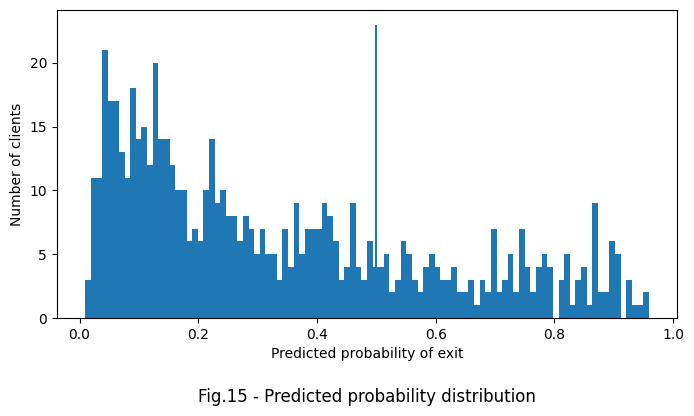

In [40]:
y_test_prob = rf.predict_proba(np.array(X_test))[:, 1]

# Estimate the number of bins
unique, counts = np.unique(y_test_prob.round(2), return_counts=True)

fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(y_test_prob, bins=100)
ax.vlines(0.5, 0, np.max(counts))

ax.set_title('Fig.15 - Predicted probability distribution', y=-0.3)
ax.set_xlabel('Predicted probability of exit')
ax.set_ylabel('Number of clients');

plt.savefig('../figures/fig_15.png')

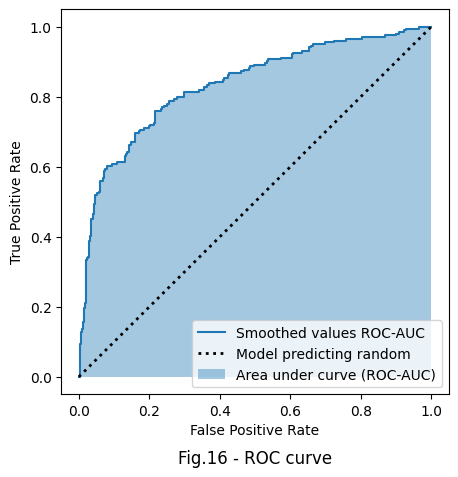

<Figure size 640x480 with 0 Axes>

In [41]:
from sklearn.metrics import roc_curve

false_positive_rates, true_positive_rates, threshold = roc_curve(y_test, y_test_prob)


# создаём график
fig, ax = plt.subplots(figsize=(5, 5))

# ROC curve
ax.plot(false_positive_rates, true_positive_rates, 
         label='Smoothed values ROC-AUC')

# Random model
ax.plot([0, 1], [0, 1], color='k', lw=2, linestyle=':', 
         label='Model predicting random ')

ax.set_title('Fig.16 - ROC curve', y=-0.2)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')

ax.fill_between(false_positive_rates, true_positive_rates, step="pre", 
                 alpha=0.4, label='Area under curve (ROC-AUC)')
ax.legend()
plt.show();

plt.savefig('../figures/fig_16.png');

### Feature selection for the best model

In [46]:
from sklearn.feature_selection import RFE
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, random_state=random_seed) 

estimator = linear_model.LogisticRegression()
X_train = pd.DataFrame(X_train, columns=X.columns.tolist())
X_test = pd.DataFrame(X_test, columns=X.columns.tolist())

selector = RFE(estimator, n_features_to_select=4, step=1)
selector = selector.fit(X_train, y_train)

# Rank features
features_most_important = selector.get_feature_names_out().tolist()
print('The most important features are: ', features_most_important)

features_least_important = [col for col in X_train.columns if col not in features_most_important]
print('Less important features are: ', features_least_important)

print(X_train.columns.tolist())
selector.ranking_

The most important features are:  ['Age', 'NumOfProducts', 'IsActiveMember', 'EstimatedSalary']
Less important features are:  ['CreditScore', 'Tenure', 'Balance', 'HasCrCard']
['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']


array([2, 1, 4, 3, 1, 5, 1, 1])

In [47]:
# Creation an instance of the RandomForest class
rf = ensemble.RandomForestClassifier(
    n_estimators=160, # trees
    criterion='gini', # criteria
    max_depth=15, # maximal depth
    min_samples_leaf = 2, # min number of objects
    random_state=random_seed  
)
X_train_rfe = X_train[features_most_important]
X_test_rfe  =  X_test[features_most_important]
# Train the model 
rf.fit(X_train_rfe, y_train)

# Predicting
y_pred_train_rfe = rf.predict(X_train_rfe)
y_pred_test_rfe = rf.predict(X_test_rfe)

# Metrics report
print('Train f1-score: {:.2f}'.format(metrics.f1_score(y_train, y_pred_train_rfe)))
print('Test  f1-score: {:.2f}'.format(metrics.f1_score(y_test, y_pred_test_rfe)))

Train f1-score: 0.85
Test  f1-score: 0.60


#### Method SelectKBest

In [44]:
from sklearn.feature_selection import SelectKBest, f_regression

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, random_state=random_seed) 

estimator = linear_model.LogisticRegression()
X_train = pd.DataFrame(X_train, columns=X.columns.tolist())
X_test = pd.DataFrame(X_test, columns=X.columns.tolist())

selector = SelectKBest(f_regression, k=4)
selector.fit(X_train, y_train)

# Rank features
features_most_important_kbest = selector.get_feature_names_out().tolist()
print('The most important features are: ', features_most_important_kbest)

features_least_important_kbest = [col for col in X_train.columns if col not in features_most_important_kbest]
print('Less important features are: ', features_least_important_kbest)


The most important features are:  ['CreditScore', 'Age', 'NumOfProducts', 'IsActiveMember']
Less important features are:  ['Tenure', 'Balance', 'HasCrCard', 'EstimatedSalary']


In [45]:
# Creation an instance of the RandomForest class
rf = ensemble.RandomForestClassifier(
    n_estimators=160, 
    criterion='gini', 
    max_depth=15, 
    min_samples_leaf = 2,  
    random_state=random_seed 
)

X_train_kbest = X_train[features_most_important_kbest]
X_test_kbest  =  X_test[features_most_important_kbest]
# Train the model 
rf.fit(X_train_kbest, y_train)

# Predicting
y_pred_train_kbest = rf.predict(X_train_kbest)
y_pred_test_kbest = rf.predict(X_test_kbest)

# Metrics report
print('Train f1-score: {:.2f}'.format(metrics.f1_score(y_train, y_pred_train)))
print('Test  f1-score: {:.2f}'.format(metrics.f1_score(y_test, y_pred_test)))
# Estimation of metrics
#print(metrics.classification_report(y_test, y_pred_test_kbest))

Train f1-score: 0.86
Test  f1-score: 0.60


Comparing two methods of feature selection such as RFE and SelectKBest it is possible to conclude that SelectKBest method shows better F1-score on validation sample.

| Feature selection method| F1-score |
|--|--|
|RFE|0.60|
|SelectKBest| 0.64|

# Conclusion

It was creared a model which successfully predicts customer outflow. The model shows satisfactory predicting value when it is learning on 4 the most valuable features.